In [17]:
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [18]:
def generate_star(n_spikes=5, inner_radius=0.4, outer_radius=1.0, n_samples=1000, center=(0, 0)):
    points = []
    angle_step = np.pi / n_spikes

    vertices = []
    for i in range(2 * n_spikes):
        angle = i * angle_step
        radius = outer_radius if i % 2 == 0 else inner_radius

        x = radius * np.cos(angle) + center[0]
        y = radius * np.sin(angle) + center[1]
        vertices.append([x, y])
    vertices.append(vertices[0])

    vertices = np.array(vertices)
    sampled_points = []

    for i in range(len(vertices) - 1):
        start_point = vertices[i]
        end_point = vertices[i + 1]

        for t in np.linspace(0, 1, n_samples // (len(vertices) - 1)):
            point = (1 - t) * start_point + t * end_point
            sampled_points.append(point)

    return np.array(sampled_points)

In [19]:
class Config:
    beta_min = 0.1
    beta_max = 20.0
    lr = 1e-3
    epochs = 2000
    batch_size = 512
    hidden_dim = 256
    num_timesteps = 1000
    data_samples = 5000

In [20]:
class ScoreModel(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.config = config

        self.time_embed = nn.Sequential(
            nn.Linear(1, config.hidden_dim),
            nn.ReLU(),
            nn.Linear(config.hidden_dim, config.hidden_dim)
        )

        self.net = nn.Sequential(
            nn.Linear(2 + config.hidden_dim, config.hidden_dim),
            nn.ReLU(),
            nn.Linear(config.hidden_dim, config.hidden_dim),
            nn.ReLU(),
            nn.Linear(config.hidden_dim, 2)
        )

    def forward(self, x, t):
        t_embed = self.time_embed(t)
        x_input = torch.cat([x, t_embed], dim=1)
        return self.net(x_input)

In [21]:
class TrainerDef:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        star = generate_star(n_samples=config.data_samples)
        self.data = torch.tensor(star, dtype=torch.float32)
        print(star.shape)

        self.dataset = TensorDataset(self.data)
        self.dataloader = DataLoader(self.dataset, batch_size=config.batch_size, shuffle=True)

        self.model = ScoreModel(config).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.lr)

        self.train_losses = []
        self.sample_losses = []

    def beta_t(self, t):
        return self.config.beta_min + t * (self.config.beta_max - self.config.beta_min)
    def int_beta(self, t):
        return self.config.beta_min * t + 0.5 * (self.config.beta_max - self.config.beta_min) * (t ** 2)
    def alpha_t(self, t):
        return torch.exp(-0.5 * self.int_beta(t))
    def sigma_t(self, t):
        return torch.sqrt(1 - self.alpha_t(t) ** 2)

    def train_epoch(self):
        self.model.train()
        total_loss = 0.0

        for (batch, ) in self.dataloader:
            batch = batch.to(self.device)

            t = torch.rand(batch.shape[0], 1, device=self.device)

            alpha = self.alpha_t(t)
            sigma = self.sigma_t(t)

            noise = torch.randn_like(batch)
            x_t = alpha * batch + sigma * noise

            score = self.model(x_t, t)
            loss = F.mse_loss(score, -noise)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * batch.shape[0]

            self.train_losses.append(total_loss/ len(self.data))

        return total_loss / len(self.data)

    def run(self):
        for epoch in range(self.config.epochs):
            loss = self.train_epoch()

            if (epoch + 1) % 100 == 0:
                print(f'Epoch: {epoch + 1}, Loss: {loss:.5f}')

    def sample(self, num_samples=1000):
        self.model.eval()

        with torch.no_grad():
            x = torch.randn(num_samples, 2, device=self.device)
            dt = 1.0 / self.config.num_timesteps

            for i in range(self.config.num_timesteps):
                t_temp = 1.0 - i * (1.0 / self.config.num_timesteps)
                t = torch.full((num_samples, 1), t_temp, device=self.device)

                beta = self.beta_t(t)
                alpha = self.alpha_t(t)
                sigma = self.sigma_t(t)

                noise = self.model(x, t)
                score = -noise / (sigma + 1e-5)

                drift = -0.5 * beta * x - beta * score
                diffusion = torch.sqrt(beta) * torch.randn_like(x)

                x = x + drift * dt + diffusion * math.sqrt(dt)

        return x.cpu().numpy()

In [22]:
config = Config()
trainer_def = TrainerDef(config)

trainer_def.run()

(5000, 2)
Epoch: 100, Loss: 0.17946
Epoch: 200, Loss: 0.17060
Epoch: 300, Loss: 0.16546
Epoch: 400, Loss: 0.15951
Epoch: 500, Loss: 0.15589
Epoch: 600, Loss: 0.15864
Epoch: 700, Loss: 0.14344
Epoch: 800, Loss: 0.14684
Epoch: 900, Loss: 0.15049
Epoch: 1000, Loss: 0.16015
Epoch: 1100, Loss: 0.15331
Epoch: 1200, Loss: 0.15771
Epoch: 1300, Loss: 0.14508
Epoch: 1400, Loss: 0.14247
Epoch: 1500, Loss: 0.15624
Epoch: 1600, Loss: 0.14725
Epoch: 1700, Loss: 0.14634
Epoch: 1800, Loss: 0.14705
Epoch: 1900, Loss: 0.14168
Epoch: 2000, Loss: 0.14742


In [23]:
class Trainer:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        star = generate_star(n_samples=config.data_samples)
        self.data = torch.tensor(star, dtype=torch.float32)
        print(star.shape)

        self.dataset = TensorDataset(self.data)
        self.dataloader = DataLoader(self.dataset, batch_size=config.batch_size, shuffle=True)

        self.model = ScoreModel(config).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.lr)

        self.train_losses = []
        self.sample_losses = []

    def beta_t(self, t):
        return self.config.beta_min + t * (self.config.beta_max - self.config.beta_min)
    def int_beta(self, t):
        return self.config.beta_min * t + 0.5 * (self.config.beta_max - self.config.beta_min) * (t ** 2)
    def alpha_t(self, t):
        return torch.exp(-0.5 * self.int_beta(t))
    def sigma_t(self, t):
        return torch.sqrt(1 - self.alpha_t(t) ** 2)

    def w_loss(self, t):
        return 1 - torch.exp( -self.int_beta(t))

    def train_epoch(self):
        self.model.train()
        total_loss = 0.0

        for (batch, ) in self.dataloader:
            batch = batch.to(self.device)

            t = torch.rand(batch.shape[0], 1, device=self.device)

            alpha = self.alpha_t(t)
            sigma = self.sigma_t(t)

            noise = torch.randn_like(batch)
            x_t = alpha * batch + sigma * noise

            score = self.model(x_t, t)

            base_loss = F.mse_loss(score, -noise)
            w = self.w_loss(t).squeeze()
            loss = (w * base_loss).mean()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * batch.shape[0]
            self.train_losses.append(total_loss/ len(self.data))

        return total_loss / len(self.data)

    def run(self):
        for epoch in range(self.config.epochs):
            loss = self.train_epoch()

            if (epoch + 1) % 100 == 0:
                print(f'Epoch: {epoch + 1}, Loss: {loss:.5f}')

    def sample(self, num_samples=1000):
        self.model.eval()

        with torch.no_grad():
            x = torch.randn(num_samples, 2, device=self.device)
            dt = 1.0 / self.config.num_timesteps

            for i in range(self.config.num_timesteps):
                t_temp = 1.0 - i * (1.0 / self.config.num_timesteps)
                t = torch.full((num_samples, 1), t_temp, device=self.device)

                beta = self.beta_t(t)
                alpha = self.alpha_t(t)
                sigma = self.sigma_t(t)

                noise = self.model(x, t)
                score = -noise / (sigma + 1e-5)

                drift = -0.5 * beta * x - beta * score
                diffusion = torch.sqrt(beta) * torch.randn_like(x)

                x = x + drift * dt + diffusion * math.sqrt(dt)

        return x.cpu().numpy()

In [24]:
config = Config()
trainer = Trainer(config)

trainer.run()

(5000, 2)
Epoch: 100, Loss: 0.12760
Epoch: 200, Loss: 0.11363
Epoch: 300, Loss: 0.12463
Epoch: 400, Loss: 0.11250
Epoch: 500, Loss: 0.11431
Epoch: 600, Loss: 0.12194
Epoch: 700, Loss: 0.11216
Epoch: 800, Loss: 0.10962
Epoch: 900, Loss: 0.11318
Epoch: 1000, Loss: 0.10992
Epoch: 1100, Loss: 0.11211
Epoch: 1200, Loss: 0.10837
Epoch: 1300, Loss: 0.10585
Epoch: 1400, Loss: 0.10488
Epoch: 1500, Loss: 0.10545
Epoch: 1600, Loss: 0.10551
Epoch: 1700, Loss: 0.11395
Epoch: 1800, Loss: 0.11386
Epoch: 1900, Loss: 0.10195
Epoch: 2000, Loss: 0.09767


In [25]:
class TrainerCosDef:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        star = generate_star(n_samples=config.data_samples)
        self.data = torch.tensor(star, dtype=torch.float32)
        print(star.shape)

        self.dataset = TensorDataset(self.data)
        self.dataloader = DataLoader(self.dataset, batch_size=config.batch_size, shuffle=True)

        self.model = ScoreModel(config).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.lr)

        self.train_losses = []

    def beta_t(self, t):
        eps = 1e-5
        t = torch.clamp(t, max=1 - eps)
        return math.pi * (torch.tan( (math.pi * t)/2 ))
    def int_beta(self, t):
        return -2 * torch.log(torch.cos((math.pi / 2) * t) + 1e-7)
    def alpha_t(self, t):
        return torch.cos( (math.pi * t)/2 )

    def sigma_t(self, t):
        return torch.sin( (math.pi * t)/2 )

    def train_epoch(self):
        self.model.train()
        total_loss = 0.0

        for (batch, ) in self.dataloader:
            batch = batch.to(self.device)

            t = torch.rand(batch.shape[0], 1, device=self.device)

            alpha = self.alpha_t(t)
            sigma = self.sigma_t(t)

            noise = torch.randn_like(batch)
            x_t = alpha * batch + sigma * noise

            score = self.model(x_t, t)

            loss = F.mse_loss(score, -noise)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * batch.shape[0]

            self.train_losses.append(total_loss/ len(self.data))

        return total_loss / len(self.data)

    def run(self):
        for epoch in range(self.config.epochs):
            loss = self.train_epoch()

            if (epoch + 1) % 100 == 0:
                print(f'Epoch: {epoch + 1}, Loss: {loss:.5f}')

    def sample(self, num_samples=1000):
        self.model.eval()

        with torch.no_grad():
            x = torch.randn(num_samples, 2, device=self.device)
            dt = 1.0 / self.config.num_timesteps

            for i in range(self.config.num_timesteps):
                t_temp = 1.0 - i * (1.0 / self.config.num_timesteps)
                t = torch.full((num_samples, 1), t_temp, device=self.device)

                beta = self.beta_t(t)
                alpha = self.alpha_t(t)
                sigma = self.sigma_t(t)

                noise = self.model(x, t)
                score = -noise / (sigma + 1e-5)

                drift = -0.5 * beta * x - beta * score
                diffusion = torch.sqrt(beta) * torch.randn_like(x)

                x = x + drift * dt + diffusion * math.sqrt(dt)

        return x.cpu().numpy()

In [26]:
config = Config()
trainer_cos_def = TrainerCosDef(config)

trainer_cos_def.run()

(5000, 2)
Epoch: 100, Loss: 0.33234
Epoch: 200, Loss: 0.30359
Epoch: 300, Loss: 0.29492
Epoch: 400, Loss: 0.28265
Epoch: 500, Loss: 0.30599
Epoch: 600, Loss: 0.27524
Epoch: 700, Loss: 0.29415
Epoch: 800, Loss: 0.28060
Epoch: 900, Loss: 0.29388
Epoch: 1000, Loss: 0.27427
Epoch: 1100, Loss: 0.27675
Epoch: 1200, Loss: 0.27447
Epoch: 1300, Loss: 0.27811
Epoch: 1400, Loss: 0.27649
Epoch: 1500, Loss: 0.27695
Epoch: 1600, Loss: 0.27383
Epoch: 1700, Loss: 0.28133
Epoch: 1800, Loss: 0.29259
Epoch: 1900, Loss: 0.27356
Epoch: 2000, Loss: 0.26917


In [27]:
class TrainerCos:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        star = generate_star(n_samples=config.data_samples)
        self.data = torch.tensor(star, dtype=torch.float32)
        print(star.shape)

        self.dataset = TensorDataset(self.data)
        self.dataloader = DataLoader(self.dataset, batch_size=config.batch_size, shuffle=True)

        self.model = ScoreModel(config).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.lr)
        self.train_losses = []

    def beta_t(self, t):
        eps = 1e-5
        t = torch.clamp(t, max=1 - eps)
        return math.pi * (torch.tan( (math.pi * t)/2 ))
    def int_beta(self, t):
        return -2 * torch.log(torch.cos((math.pi / 2) * t) + 1e-7)
    def alpha_t(self, t):
        return torch.cos( (math.pi * t)/2 )

    def sigma_t(self, t):
        return torch.sin( (math.pi * t)/2 )

    def w_loss(self, t):
        return 1 - torch.exp( -self.int_beta(t))

    def train_epoch(self):
        self.model.train()
        total_loss = 0.0

        for (batch, ) in self.dataloader:
            batch = batch.to(self.device)

            t = torch.rand(batch.shape[0], 1, device=self.device)

            alpha = self.alpha_t(t)
            sigma = self.sigma_t(t)

            noise = torch.randn_like(batch)
            x_t = alpha * batch + sigma * noise

            score = self.model(x_t, t)

            base_loss = F.mse_loss(score, -noise)
            w = self.w_loss(t).squeeze()
            loss = (w * base_loss).mean()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * batch.shape[0]

            self.train_losses.append(total_loss/ len(self.data))

        return total_loss / len(self.data)

    def run(self):
        for epoch in range(self.config.epochs):
            loss = self.train_epoch()

            if (epoch + 1) % 100 == 0:
                print(f'Epoch: {epoch + 1}, Loss: {loss:.5f}')

    def sample(self, num_samples=1000):
        self.model.eval()

        with torch.no_grad():
            x = torch.randn(num_samples, 2, device=self.device)
            dt = 1.0 / self.config.num_timesteps

            for i in range(self.config.num_timesteps):
                t_temp = 1.0 - i * (1.0 / self.config.num_timesteps)
                t = torch.full((num_samples, 1), t_temp, device=self.device)

                beta = self.beta_t(t)
                alpha = self.alpha_t(t)
                sigma = self.sigma_t(t)

                noise = self.model(x, t)
                score = -noise / (sigma + 1e-5)

                drift = -0.5 * beta * x - beta * score
                diffusion = torch.sqrt(beta) * torch.randn_like(x)

                x = x + drift * dt + diffusion * math.sqrt(dt)

        return x.cpu().numpy()

In [28]:
config = Config()
trainer_cos = TrainerCos(config)

trainer_cos.run()

(5000, 2)
Epoch: 100, Loss: 0.16021
Epoch: 200, Loss: 0.15227
Epoch: 300, Loss: 0.14770
Epoch: 400, Loss: 0.15015
Epoch: 500, Loss: 0.14839
Epoch: 600, Loss: 0.14945
Epoch: 700, Loss: 0.14206
Epoch: 800, Loss: 0.14813
Epoch: 900, Loss: 0.14369
Epoch: 1000, Loss: 0.14462
Epoch: 1100, Loss: 0.14371
Epoch: 1200, Loss: 0.13925
Epoch: 1300, Loss: 0.14020
Epoch: 1400, Loss: 0.13849
Epoch: 1500, Loss: 0.14191
Epoch: 1600, Loss: 0.13497
Epoch: 1700, Loss: 0.13808
Epoch: 1800, Loss: 0.13679
Epoch: 1900, Loss: 0.13594
Epoch: 2000, Loss: 0.14193


In [29]:
train_losses_star_default = trainer_def.train_losses
train_losses_star = trainer.train_losses
train_losses_star_cos = trainer_cos.train_losses
train_losses_star_cos_def = trainer_cos_def.train_losses

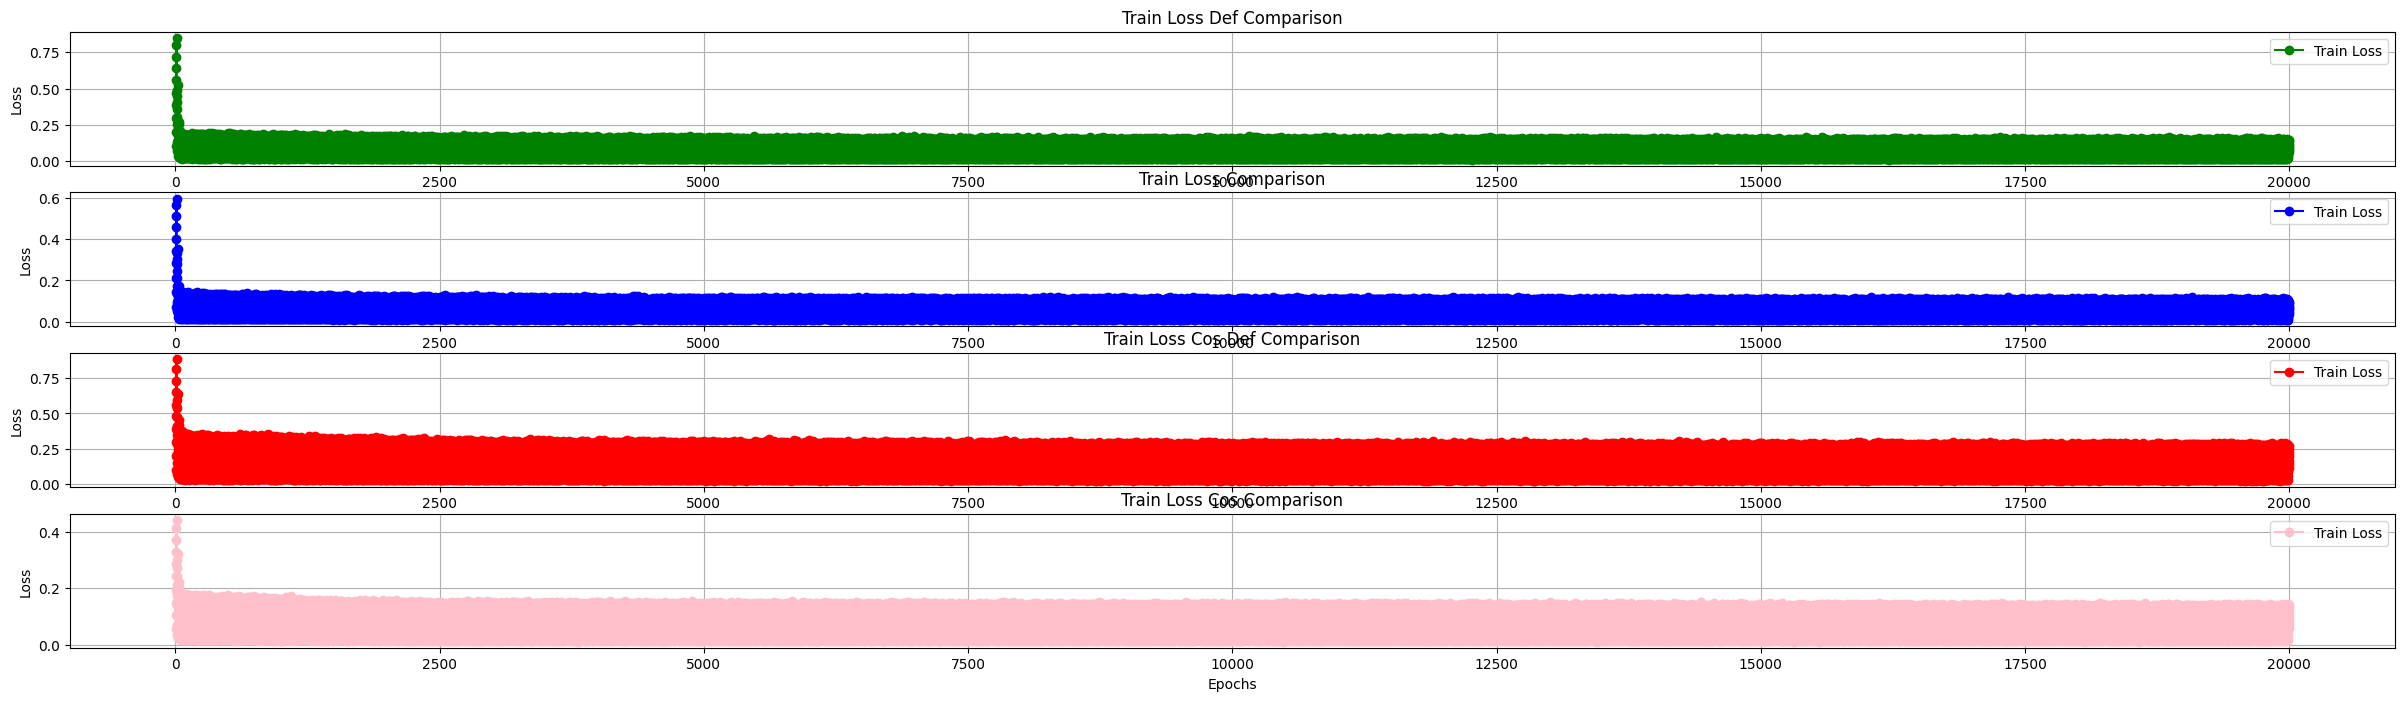

In [30]:
fig, axs = plt.subplots(4, 1, figsize=(30, 8))

axs[0].plot(range(1, len(train_losses_star_default) + 1), train_losses_star_default, label='Train Loss', color='green', marker='o')
axs[0].set_title('Train Loss Def Comparison')

axs[1].plot(range(1, len(train_losses_star) + 1), train_losses_star, label='Train Loss', color='blue', marker='o')
axs[1].set_title('Train Loss Comparison')

axs[2].plot(range(1, len(train_losses_star_cos_def) + 1), train_losses_star_cos_def, label='Train Loss', color='red', marker='o')
axs[2].set_title('Train Loss Cos Def Comparison')

axs[3].plot(range(1, len(train_losses_star_cos) + 1), train_losses_star_cos, label='Train Loss', color='pink', marker='o')
axs[3].set_title('Train Loss Cos Comparison')


for i in range(4):
  axs[i].set_xlabel('Epochs')
  axs[i].set_ylabel('Loss')
  axs[i].legend()
  axs[i].grid()

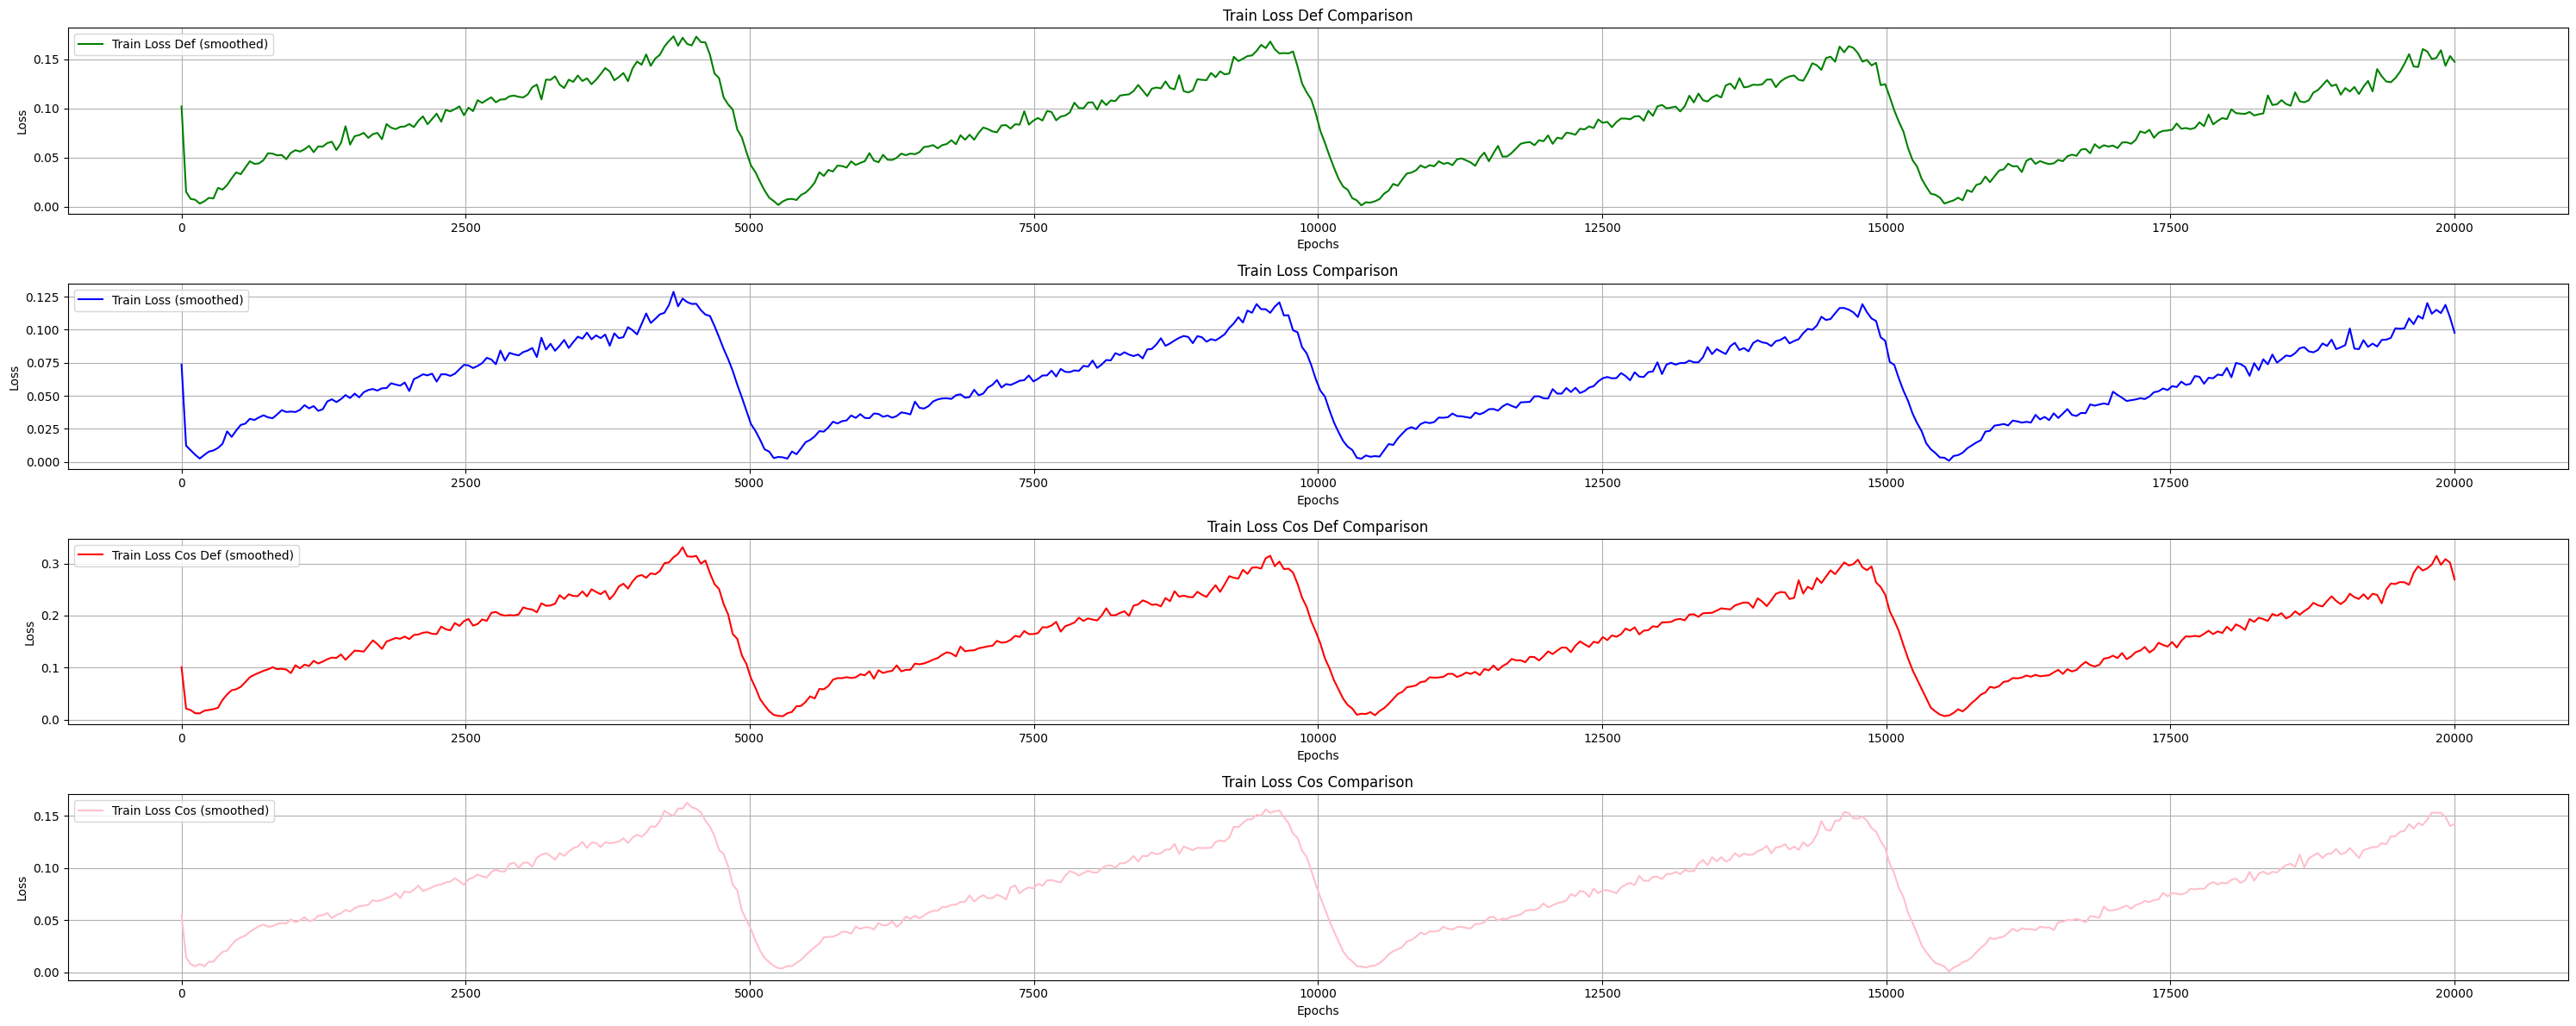

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

loss_lists = [
    (train_losses_star_default, 'Train Loss Def (smoothed)', 'green'),
    (train_losses_star, 'Train Loss (smoothed)', 'blue'),
    (train_losses_star_cos_def, 'Train Loss Cos Def (smoothed)', 'red'),
    (train_losses_star_cos, 'Train Loss Cos (smoothed)', 'pink')

]
titles = [
    'Train Loss Def Comparison',
    'Train Loss Comparison',
    'Train Loss Cos Def Comparison',
    'Train Loss Cos Comparison'
]

fig, axs = plt.subplots(4, 1, figsize=(30, 12))

for i, (loss_data, label, color) in enumerate(loss_lists):
    x = np.arange(1, len(loss_data) + 1)
    y = np.array(loss_data)
    x_smooth = np.linspace(x.min(), x.max(), 500)
    y_smooth = make_interp_spline(x, y, k=3)(x_smooth)

    axs[i].plot(x_smooth, y_smooth, label=label, color=color)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()

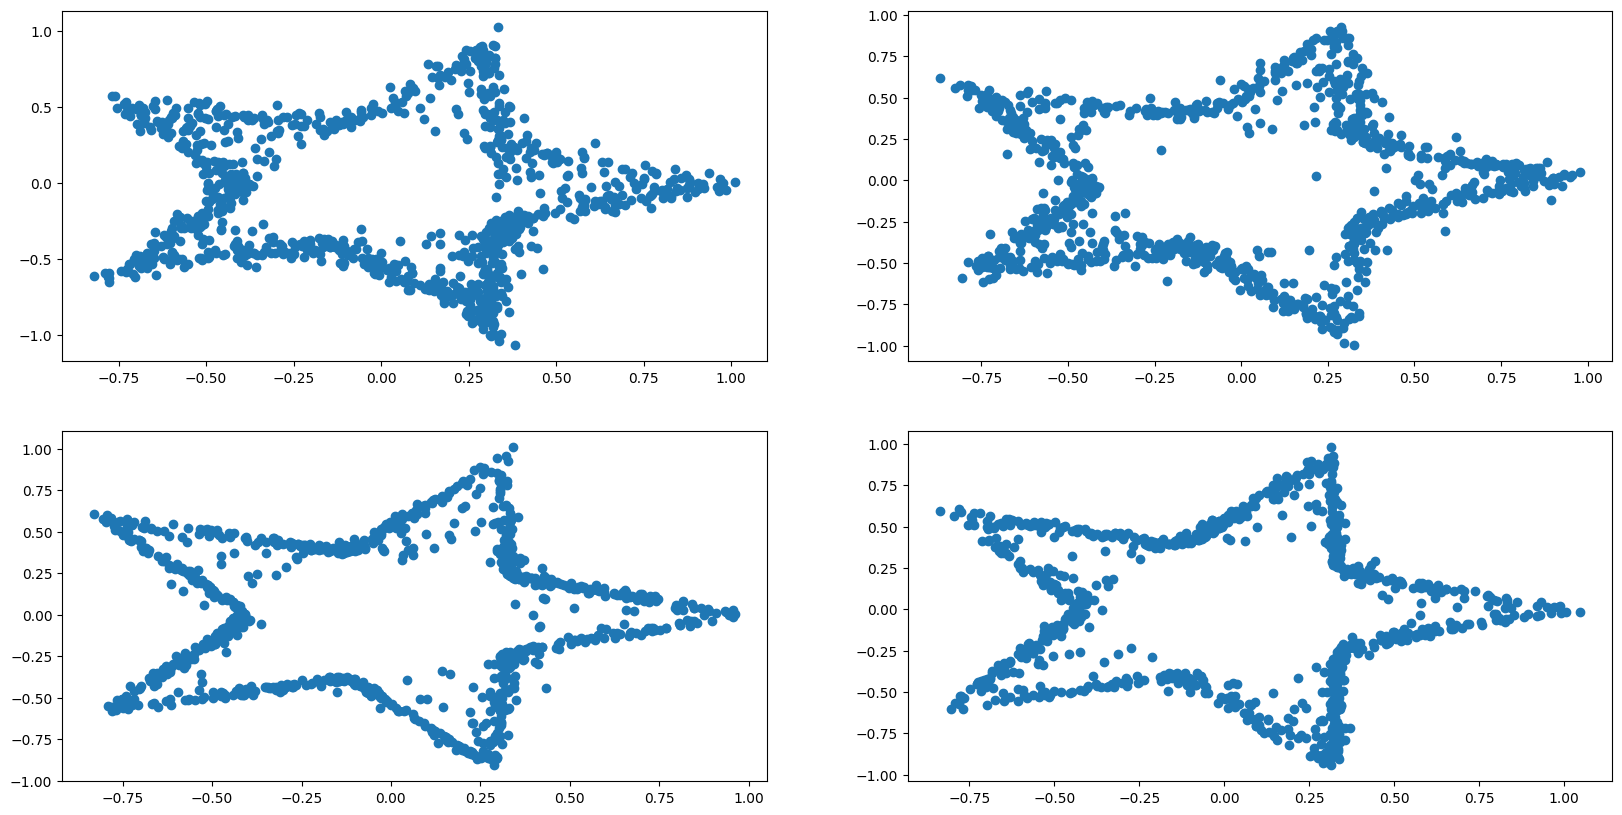

In [32]:
samples_def = trainer_def.sample(1000)
samples = trainer.sample(1000)
samples_cos_def = trainer_cos_def.sample(1000)
samples_cos = trainer_cos.sample(1000)

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0][0].scatter(samples_def[:, 0], samples_def[:, 1])
axs[0][1].scatter(samples[:, 0], samples[:, 1])
axs[1][0].scatter(samples_cos_def[:, 0], samples_cos_def[:, 1])
axs[1][1].scatter(samples_cos[:, 0], samples_cos[:, 1])

plt.show()

Использование взвешенной функции потерь приводит к более плавному изменению значения лосса, чем при обычном подсчете. Это снижает вероятность резких изменений в весах модели во время обучения, обеспечивая более стабильный и постепенный процесс улучшения